In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as patch
import matplotlib.lines as ln
import matplotlib.markers as mk
import numpy as np
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as rscore
from sklearn.metrics import explained_variance_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import statistics

In [2]:
# Read in datasets and clean data

cancer_rates = pd.read_csv("Cancer Rates.csv")
cancer_rates_by_race = pd.read_csv("Cancer Rates Race.csv")

for idx, row in cancer_rates.iterrows():
    # drop rows with unreliable data
    if "Unreliable" in row["Mortality-Incidence Age-Adjusted Rate Ratio"]:
        cancer_rates = cancer_rates.drop(idx)

# convert Mortality-Incidence Age-Adjusted Rate Ratio column to floats
cancer_rates["Mortality-Incidence Age-Adjusted Rate Ratio"] = cancer_rates["Mortality-Incidence Age-Adjusted Rate Ratio"].astype('float')
cancer_rates["Year"] = cancer_rates["Year"].astype('int')

In [3]:
# Get list of leading cancer sites and list of years

leading_cancer_sites = []
for idx, row in cancer_rates.iterrows():
    if row["Leading Cancer Sites"] not in leading_cancer_sites:
        leading_cancer_sites.append(row["Leading Cancer Sites"])

years = []
for year in list(cancer_rates["Year"]):
    if year not in years:
        years.append(year)

In [4]:
def sum_statistics_by_site_and_year(df, site, year):
    """ Gets summary statistics for a given cancer site and year
    
    param df: the main dataframe of cancer data
    param site: the leading cancer site to get statistics for
    param year: the year to get statistics for
    return: a dict, where keys = the columns of the DataFrame, and values = the mean of all the rows in each column
    """
    df = df[df["Leading Cancer Sites"] == site] # filter to only include the cancer site of interest
    df = df[df["Year"] == year] # filter to only include the year of interest
    return {"Mortality-Incidence Age-Adjusted Rate Ratio": df.mean()["Mortality-Incidence Age-Adjusted Rate Ratio"]*100,
            "Mortality Age-Adjusted Rate (per 100,000)": df.mean()["Mortality Age-Adjusted Rate (per 100,000)"],
           "Incidence Age-Adjusted Rate (per 100,000)": df.mean()["Incidence Age-Adjusted Rate (per 100,000)"]}

In [5]:
def get_ax():
    """ Creates a matplotlib axis to plot on
    """
    ax = plt.subplot()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    return ax

def plot_year(category):
    d = {}
    for year in list(cancer_rates["Year"]):
        d.update({str(year):sum_statistics_by_site_and_year(cancer_rates, category, year)})
    df = pd.DataFrame(d).T
    ax = get_ax()
    df.plot(ax=ax)

In [6]:
def plot_year_all_sites(year):
    all_sites = {}
    for site in leading_cancer_sites:
        all_sites.update({site: sum_statistics_by_site_and_year(cancer_rates, site, year)})
    
    mortality = []
    incidence = []
    ratio = []
    
    for site in all_sites:
        
        ratio.append(all_sites[site]["Mortality-Incidence Age-Adjusted Rate Ratio"])
        mortality.append(all_sites[site]["Mortality Age-Adjusted Rate (per 100,000)"])
        incidence.append(all_sites[site]["Incidence Age-Adjusted Rate (per 100,000)"])
    
    
    for l in [mortality, incidence, ratio]:
        for item in l:
            item = int(item)
    
    mortality_sum = sum(mortality)
    incidence_sum = sum(incidence)
    ratio_tot = (mortality_sum / incidence_sum) * 100

    return {"Mortality-Incidence Age-Adjusted Rate Ratio": ratio_tot,
            "Mortality Age-Adjusted Rate (per 100,000)": mortality,
           "Incidence Age-Adjusted Rate (per 100,000)": incidence}

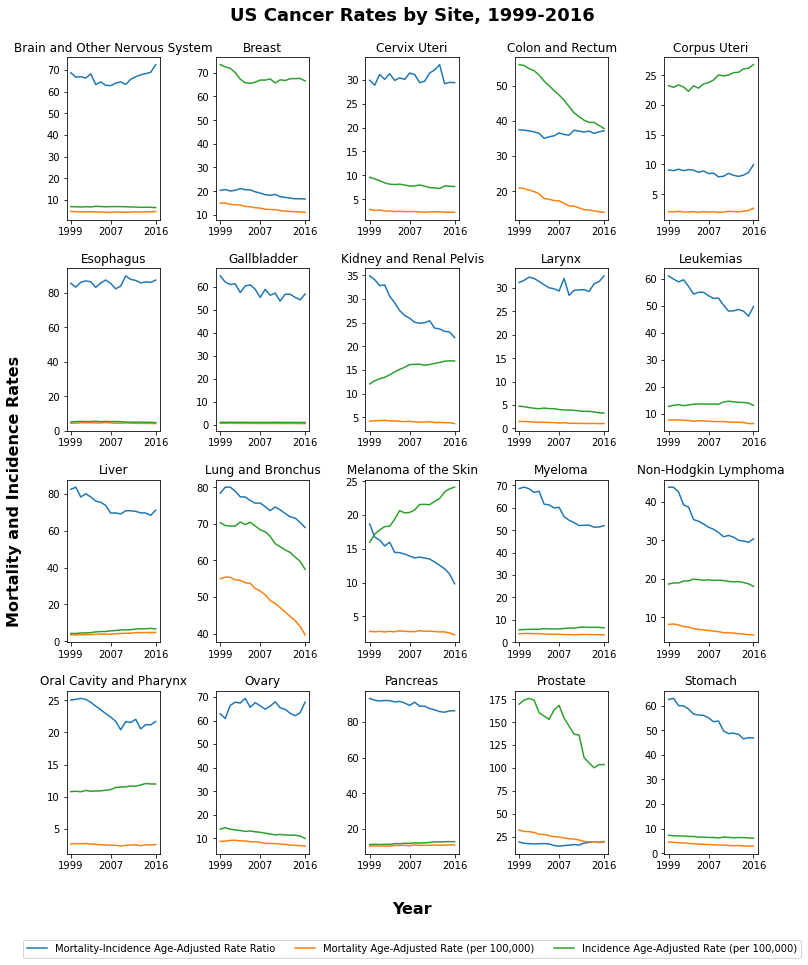

In [7]:
# Plot cancer statistics over time, for each leading cancer site

fig, ax = plt.subplots(4, 5)

categories = 0 # track position in the leading_cancer_sites list
rows = 0 # track row of subplot

while rows <= 3:
    columns = 0 # track column of subplot
    while columns <= 4:
        filtered_df_by_site = cancer_rates[cancer_rates["Leading Cancer Sites"] == leading_cancer_sites[categories]]

        d = {} # key = year, value = dict (where keys = cancer statistic columns and values = means for each statistic for that year)
        for year in years:
            # get cancer statistics for the site and year and add to dictionary
            d.update({year:sum_statistics_by_site_and_year(filtered_df_by_site, leading_cancer_sites[categories], year)})

        # convert the dictionary to a DataFrame and plot it
        df = pd.DataFrame(d).T
        df.plot(ax=ax[rows][columns], legend=False, title=leading_cancer_sites[categories])
        ax[rows][columns].set_xticks([1999, 2007, 2016])
        
        # increment counters
        columns += 1
        categories += 1
        
        # track progress, as this cell takes a long time to run
    rows += 1

fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
ax.flatten()[-3].legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), ncol=3) # try to make one legend for the entire figure
fig.set_size_inches(12,14)
fig.subplots_adjust(top=0.93, left=0.1, right=0.9, bottom=0.14, wspace=0.6, hspace=0.3)

fig.text(0.04,0.5, "Mortality and Incidence Rates", ha="center", va="center", fontsize=16, fontdict=dict(weight='bold'), rotation=90)
fig.text(0.5,0.085, "Year", ha="center", va="center", fontsize=16, fontdict=dict(weight='bold'))
fig.suptitle("US Cancer Rates by Site, 1999-2016", fontsize=18, fontweight="bold")

fig.savefig("cancer_rates_over_time.svg")

plt.show("off")

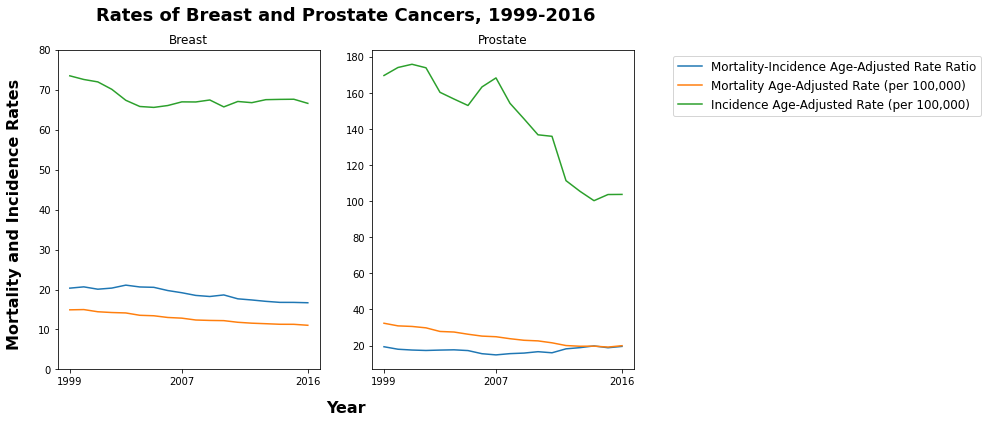

In [8]:
# Did not use in final project

fig, ax = plt.subplots(1, 2)

to_plot = ["Breast", "Prostate"]

categories = 0 # track position in the leading_cancer_sites list
rows = 0 # track row of subplot

while rows <= 0:
    columns = 0 # track column of subplot
    while columns <= 1:
        filtered_df_by_site = cancer_rates[cancer_rates["Leading Cancer Sites"] == to_plot[categories]]

        d = {} # key = year, value = dict (where keys = cancer statistic columns and values = means for each statistic for that year)
        for year in years:
            # get cancer statistics for the site and year and add to dictionary
            d.update({year:sum_statistics_by_site_and_year(filtered_df_by_site, to_plot[categories], year)})

        # convert the dictionary to a DataFrame and plot it
        df = pd.DataFrame(d).T
        df.plot(ax=ax[columns], legend=False)
        ax[columns].set_xticks([1999, 2007, 2016])
        ax[columns].set_title(to_plot[categories], fontsize=12)
        
        # increment counters
        columns += 1
        categories += 1
        
        # track progress, as this cell takes a long time to run
    rows += 1
    
lgd = ax[1].legend(loc='upper right', bbox_to_anchor=(2.35, 1), ncol=1, fontsize=12) # try to make one legend for the entire figure
fig.set_size_inches(10,6)
fig.subplots_adjust(top=0.88, left=0.1, right=0.9, bottom=0.14, wspace=0.2, hspace=0.3)
fig.text(0.04,0.5, "Mortality and Incidence Rates", ha="center", va="center", fontsize=16, fontdict=dict(weight='bold'), rotation=90)
fig.text(0.5,0.05, "Year", ha="center", va="center", fontsize=16, fontdict=dict(weight='bold'))
fig.suptitle("Rates of Breast and Prostate Cancers, 1999-2016", fontsize=18, fontweight="bold")

ax[0].set_ylim([0,80])

fig.savefig('breast_prostate_rates_over_time.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show("off")

In [9]:
# Load and clean up funding data

funding_data = pd.read_csv("Funding Data.csv")

for index, row in funding_data.iterrows():
    for col in funding_data.columns:
        if funding_data.at[index, col] == "*" or funding_data.at[index, col] == "**" or funding_data.at[index, col] == "---":
            funding_data.at[index, col] = np.nan

for col in funding_data.columns[1:]:
    funding_data[col] = funding_data[col].astype("float")

funding_data.head()

,Cancer,Incidence,Mort.,US Gov't YLL (thousands),WHO DALY (thousands),Medicare Spend$ (millions),National spend $ (billions),Lost prod. (billions),NCI Funding (millions),AYLL,YLLPI
0,Bladder,70530.0,14680.0,154.4,128.7,1023.0,3.466,1.977,22.6,10.52,2.19
1,"Brain, ONS",22020.0,13140.0,290.8,NaN,293.0,3.715,5.851,193.1,22.13,13.21
2,Breast,209060.0,40230.0,761.3,612.5,1375.0,13.886,10.879,631.2,18.92,3.64
3,Cervix,12200.0,4210.0,104.7,114.1,73.0,1.425,1.808,76.5,24.87,8.58
4,Colon/rectum,142570.0,51370.0,764.6,542.1,3101.0,12.155,12.802,270.4,14.88,5.36


In [10]:
# Calculate linear regressions

def plot_regressions(df, x, y, ax, color):
    df = df.dropna()
    
    r = LinearRegression()
    r.fit(df[x].values.reshape(-1,1),
      df[y].values.reshape(-1,1))
    
    slope = (r.coef_)[0][0]
    intercept = (r.intercept_)[0]
    
    y0 = (ax.get_xlim()[0])*slope + intercept
    y1 = (ax.get_xlim()[1])*slope + intercept
    
    ax.plot((ax.get_xlim()[0], ax.get_xlim()[1]), (y0, y1), c=color, dashes=[5,2,1,2], alpha=0.5, zorder=0.1)

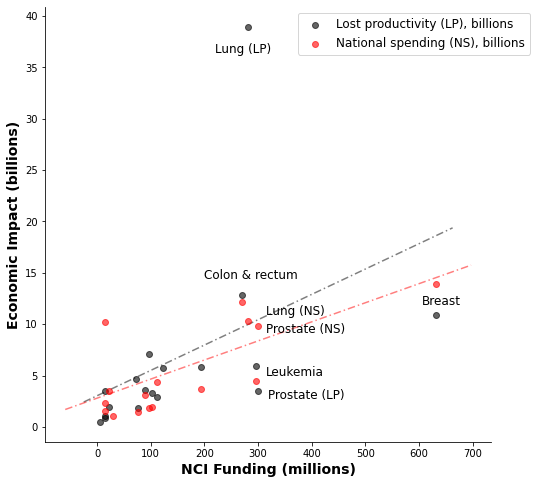

In [11]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(funding_data["NCI Funding (millions)"], funding_data["Lost prod. (billions)"], c="black", label="Lost productivity (LP), billions", alpha=0.6)
ax.scatter(funding_data["NCI Funding (millions)"], funding_data["National spend $ (billions)"], c="red", label="National spending (NS), billions", alpha=0.6)

ax.set_xlabel("NCI Funding (millions)", fontsize=14, fontdict=dict(weight='bold'))
ax.set_ylabel("Economic Impact (billions)", fontsize=14, fontdict=dict(weight='bold'))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plot_regressions(funding_data, "NCI Funding (millions)", "Lost prod. (billions)", ax=ax, color="black")
plot_regressions(funding_data,  "NCI Funding (millions)", "National spend $ (billions)", ax=ax, color="red")


plt.annotate("Lung (LP)", (220, 36), textcoords="offset points", xytext=(0,4), fontsize=12)
plt.annotate("Lung (NS)", (315, 10.5), textcoords="offset points", xytext=(0,4), fontsize=12)
plt.annotate("Breast", (605, 11.5), textcoords="offset points", xytext=(0,4), fontsize=12)
plt.annotate("Leukemia", (296, 4.6), textcoords="offset points", xytext=(10,4), fontsize=12)
plt.annotate("Prostate (LP)", (300, 2.4), textcoords="offset points", xytext=(10,4), fontsize=12)
plt.annotate("Prostate (NS)", (296, 9.2), textcoords="offset points", xytext=(10,0), fontsize=12)
plt.annotate("Colon & rectum", (200, 14), textcoords="offset points", xytext=(0,4), fontsize=12)


plt.legend(loc="upper right", fontsize=12, bbox_to_anchor=(1.1, 1))
plt.show("off")

In [12]:
color_dict = {1: "b",
              2: "g",
              3: "r",
              4: "m",
              5: "y",
              6: "c",
              7: "darkorange",
              8: "black",
              9: "firebrick",
              10: "pink",
              11: "grey",
              12: "lightcoral",
              13: "olive",
              14: "aquamarine",
              15: "navy",
              16: "plum",
              17: "dodgerblue",
              18: "darkred",
              19: "darkgoldenrod",
              20: "mediumpurple",
              21: "royalblue"
             }

funding_data_colors = funding_data.copy()
funding_data_colors["color"] = ""
color = 1
for index, row in funding_data_colors.iterrows():
    funding_data_colors.at[index, "color"] = color_dict[color]
    color += 1
funding_data_colors.head()

,Cancer,Incidence,Mort.,US Gov't YLL (thousands),WHO DALY (thousands),Medicare Spend$ (millions),National spend $ (billions),Lost prod. (billions),NCI Funding (millions),AYLL,YLLPI,color
0,Bladder,70530.0,14680.0,154.4,128.7,1023.0,3.466,1.977,22.6,10.52,2.19,b
1,"Brain, ONS",22020.0,13140.0,290.8,NaN,293.0,3.715,5.851,193.1,22.13,13.21,g
2,Breast,209060.0,40230.0,761.3,612.5,1375.0,13.886,10.879,631.2,18.92,3.64,r
3,Cervix,12200.0,4210.0,104.7,114.1,73.0,1.425,1.808,76.5,24.87,8.58,m
4,Colon/rectum,142570.0,51370.0,764.6,542.1,3101.0,12.155,12.802,270.4,14.88,5.36,y


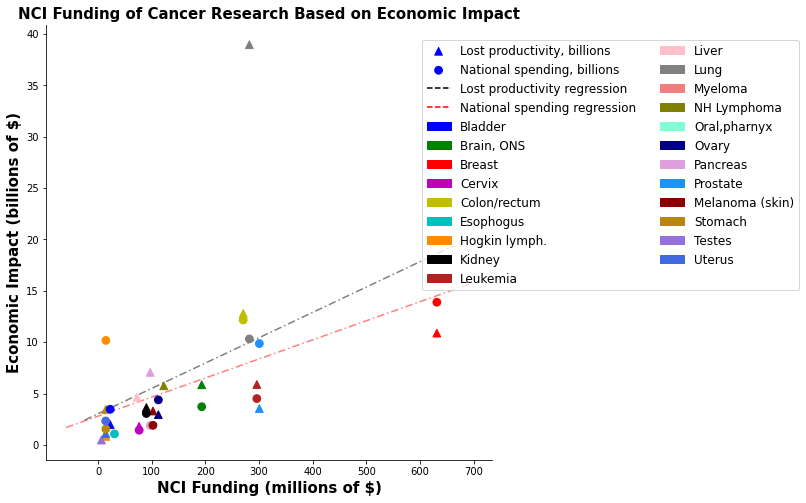

In [13]:
# Graph for NCI Funding based on economic impact

fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(funding_data_colors["NCI Funding (millions)"], funding_data_colors["Lost prod. (billions)"], c=funding_data_colors["color"], marker="^", s=60, label="Lost productivity, billions")
ax.scatter(funding_data_colors["NCI Funding (millions)"], funding_data_colors["National spend $ (billions)"], c=funding_data_colors["color"], s=60, label="National spending, billions")

ax.set_xlabel("NCI Funding (millions of $)", fontsize=15, fontdict=dict(weight='bold'))
ax.set_ylabel("Economic Impact (billions of $)", fontsize=15, fontdict=dict(weight='bold'))
ax.set_title("NCI Funding of Cancer Research Based on Economic Impact", fontsize=15, fontdict=dict(weight='bold'))


ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plot_regressions(funding_data_colors, "NCI Funding (millions)", "Lost prod. (billions)", ax=ax, color="black")
plot_regressions(funding_data_colors,  "NCI Funding (millions)", "National spend $ (billions)", ax=ax, color="red")


handles, labels = ax.get_legend_handles_labels()
lp_regression = ln.Line2D([], [], color='black', linestyle="dashed",
                          markersize=15, label='Lost productivity regression')
ns_regression = ln.Line2D([], [], color='red', linestyle="dashed",
                          markersize=15, label='National Spending regression')
handles.append(lp_regression)
handles.append(ns_regression)
labels.append("Lost productivity regression")
labels.append("National spending regression")

for index, row in funding_data_colors.iterrows():
    patch_to_add = patch.Patch(color=row["color"], label=row["Cancer"])
    handles.append(patch_to_add)
    labels.append(row["Cancer"])  

    
plt.legend(handles=handles, labels=labels, loc="upper right", fontsize=12, bbox_to_anchor=(1.7, .98), ncol=2)
fig.savefig("economic_impact_NCI_funding.svg", bbox_inches="tight")

plt.show("off")

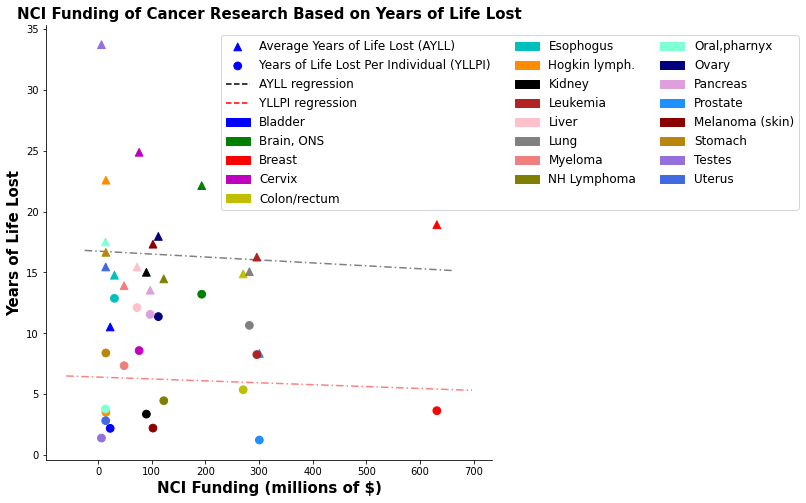

In [14]:
# Graph for NCI Funding based on years of life lost

fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(funding_data["NCI Funding (millions)"], funding_data["AYLL"], label="Average Years of Life Lost (AYLL)", c=funding_data_colors["color"], s=60, marker="^")
ax.scatter(funding_data["NCI Funding (millions)"], funding_data["YLLPI"], label="Years of Life Lost Per Individual (YLLPI)", c=funding_data_colors["color"], s=60)

ax.set_xlabel("NCI Funding (millions of $)", fontsize=15, fontdict=dict(weight='bold'))
ax.set_ylabel("Years of Life Lost", fontsize=15, fontdict=dict(weight='bold'))
ax.set_title("NCI Funding of Cancer Research Based on Years of Life Lost", fontsize=15, fontdict=dict(weight='bold'))



ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


plot_regressions(funding_data, "NCI Funding (millions)", "AYLL", ax=ax, color="black")
plot_regressions(funding_data, "NCI Funding (millions)", "YLLPI", ax=ax, color="red")

handles, labels = ax.get_legend_handles_labels()
lp_regression = ln.Line2D([], [], color='black', linestyle="dashed",
                          markersize=15, label='AYLL regression')
ns_regression = ln.Line2D([], [], color='red', linestyle="dashed",
                          markersize=15, label='YLLPI regression')
handles.append(lp_regression)
handles.append(ns_regression)
labels.append("AYLL regression")
labels.append("YLLPI regression")

for index, row in funding_data_colors.iterrows():
    patch_to_add = patch.Patch(color=row["color"], label=row["Cancer"])
    handles.append(patch_to_add)
    labels.append(row["Cancer"])
    
plt.legend(handles=handles, labels=labels, loc="upper right", fontsize=12, bbox_to_anchor=(1.7, 0.99), ncol=3)
fig.savefig("years_of_life_lost_NCI_funding.svg", bbox_inches="tight")

plt.show("off")

In [15]:
# Create DataFrame for proportions (NCI funding $ per ____)

total_NCI_funding = funding_data["NCI Funding (millions)"].sum()
proportion_cancer_funding = funding_data.copy()

proportion_cancer_funding["NCI funding $ per incident"] = 0
proportion_cancer_funding = proportion_cancer_funding.set_index("Cancer")
for index, row in proportion_cancer_funding.iterrows():
    proportion_cancer_funding.at[index, "NCI funding $ per incident (thousands)"] = ((row["NCI Funding (millions)"] * 1000000) / float(row["Incidence"])) / 1000
    proportion_cancer_funding.at[index, "NCI funding $ per mortality (thousands)"] = ((row["NCI Funding (millions)"] * 1000000) / float(row["Mort."])) / 1000
    proportion_cancer_funding.at[index, "NCI funding $ per US Gov't YLL (thousands)"] = (row["NCI Funding (millions)"] * 1000000) / float(row["US Gov't YLL (thousands)"])
    proportion_cancer_funding.at[index, "NCI funding $ per AYLL"] = (row["NCI Funding (millions)"] * 1000000) / float(row["AYLL"])
    proportion_cancer_funding.at[index, "NCI funding $ per WHO DALY"] = (row["NCI Funding (millions)"] * 1000000) / (float(row["WHO DALY (thousands)"]*1000))

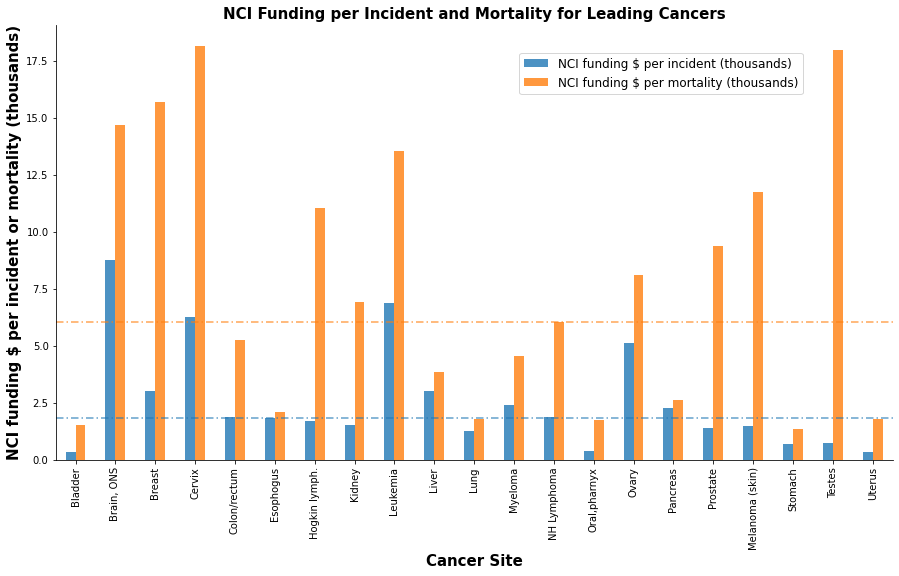

In [16]:
# Graph of NCI funding per incident and NCI funding per mortality

fig, ax = plt.subplots(figsize=(15,8))

proportion_cancer_funding.plot.bar(y=["NCI funding $ per incident (thousands)", "NCI funding $ per mortality (thousands)"], ax=ax, alpha=0.8)

med_NCI_funding_per_incident = proportion_cancer_funding["NCI funding $ per incident (thousands)"].median()
med_NCI_funding_per_mortality = proportion_cancer_funding["NCI funding $ per mortality (thousands)"].median()
ax.axhline(med_NCI_funding_per_incident, c="tab:blue", dashes=[5,2,1,2], alpha=0.7)
ax.axhline(med_NCI_funding_per_mortality, c="tab:orange", dashes=[5,2,1,2], alpha=0.7)

ax.set_title("NCI Funding per Incident and Mortality for Leading Cancers", fontsize=15, fontdict=dict(weight='bold'))
ax.set_ylabel("NCI funding $ per incident or mortality (thousands)", fontsize=15, fontdict=dict(weight='bold'))
ax.set_xlabel("Cancer Site", fontsize=15, fontdict=dict(weight='bold'))
ax.legend(bbox_to_anchor=(0.9, 0.95), fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(bbox_to_anchor=(0.9, 0.95), fontsize=12)

fig.savefig("funding_per_incident_and_mortality.svg", bbox_inches="tight")

plt.show("off")

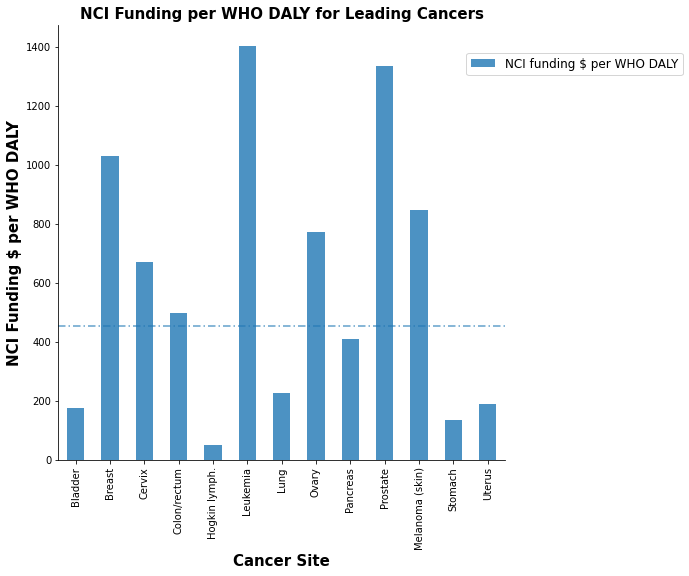

In [17]:
# Graph of NCI funding per WHO DALY (didn't end up using this)

fig, ax = plt.subplots(figsize=(8,8))

med_NCI_funding_per_DALY = proportion_cancer_funding["NCI funding $ per WHO DALY"].dropna().median()

proportion_cancer_funding.dropna().plot.bar(y="NCI funding $ per WHO DALY", ax=ax, alpha=0.8)

ax.axhline(med_NCI_funding_per_DALY, c="tab:blue", dashes=[5,2,1,2], alpha=0.7)

ax.set_title("NCI Funding per WHO DALY for Leading Cancers", fontsize=15, fontdict=dict(weight='bold'))
ax.set_ylabel("NCI Funding $ per WHO DALY", fontsize=15, fontdict=dict(weight='bold'))
ax.set_xlabel("Cancer Site", fontsize=15, fontdict=dict(weight='bold'))
ax.legend(bbox_to_anchor=(0.9, 0.95), fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(bbox_to_anchor=(0.9, 0.95), fontsize=12)


plt.show("off")

In [18]:
# Get r2 values for the NCI funding based on economic impact regressions

def get_r2(df, x, y, drop=None):
    """ Calculates r2 value of a regression
    
    param df: dataset that regression was performed on
    param x: x var of regression
    param y: y var of regression
    param drop: name of row to drop (if it's an outlier)
    """
    df = df.dropna()
    
    # use this to drop an outlier from the data
    if drop != None:
        cancers = dict(df["Cancer"])
        for cancer_idx in cancers:
            if cancers[cancer_idx] == drop:
                df = df.drop(cancer_idx)
    
    r = LinearRegression()
    r.fit(df[x].values.reshape(-1,1),
      df[y].values.reshape(-1,1))
    
    slope = (r.coef_)[0][0]
    intercept = (r.intercept_)[0]
    
    true = df[y].values.reshape(-1,1)
    x = df[x].values.reshape(-1,1)
    predicted = r.predict(x)
    
    return rscore(true, predicted)


print("r2 for National spend", get_r2(funding_data_colors, "NCI Funding (millions)", "National spend $ (billions)"))
print("r2 for Lost productivity", get_r2(funding_data_colors, "NCI Funding (millions)", "Lost prod. (billions)", drop="Lung")) 

r2 for National spend 0.5304767705820186
r2 for Lost productivity 0.540014390900872


In [19]:
# Load 5 year survival rate data

survival_rates = pd.read_csv("USCS_SurvivalAllCancersRace.csv")
cancer_types = []
for index, row in survival_rates.iterrows():
    if row["CancerType"] not in cancer_types:
        cancer_types.append(row["CancerType"])

survival_rates["White 5-year relative survival %"] = 0
survival_rates["Black 5-year relative survival %"] = 0
survival_rates["Other 5-year relative survival%"] = 0

In [20]:
# Clean 5-year survival rate data

survival_rates_clean = survival_rates.copy()
survival_rates_clean = survival_rates_clean[:19]
for index, row in survival_rates.iterrows():
    if row["Race"] == "White":
        for id2, row2 in survival_rates_clean.iterrows():
            if row2["CancerType"] == row["CancerType"]:
                survival_rates_clean.at[id2, "White 5-year relative survival %"] = row["5-yearRelativeSurvival%"]
                break
    elif row["Race"] == "Black":
        for id2, row2 in survival_rates_clean.iterrows():
            if row2["CancerType"] == row["CancerType"]:
                survival_rates_clean.at[id2, "Black 5-year relative survival %"] = row["5-yearRelativeSurvival%"]
                break
        
    elif row["Race"] == "Other":
        for id2, row2 in survival_rates_clean.iterrows():
            if row2["CancerType"] == row["CancerType"]:
                survival_rates_clean.at[id2, "Other 5-year relative survival %"] = row["5-yearRelativeSurvival%"]
                break
survival_rates_clean = survival_rates_clean.drop(columns="5-yearRelativeSurvival%")
survival_rates_clean = survival_rates_clean.set_index("CancerType")    

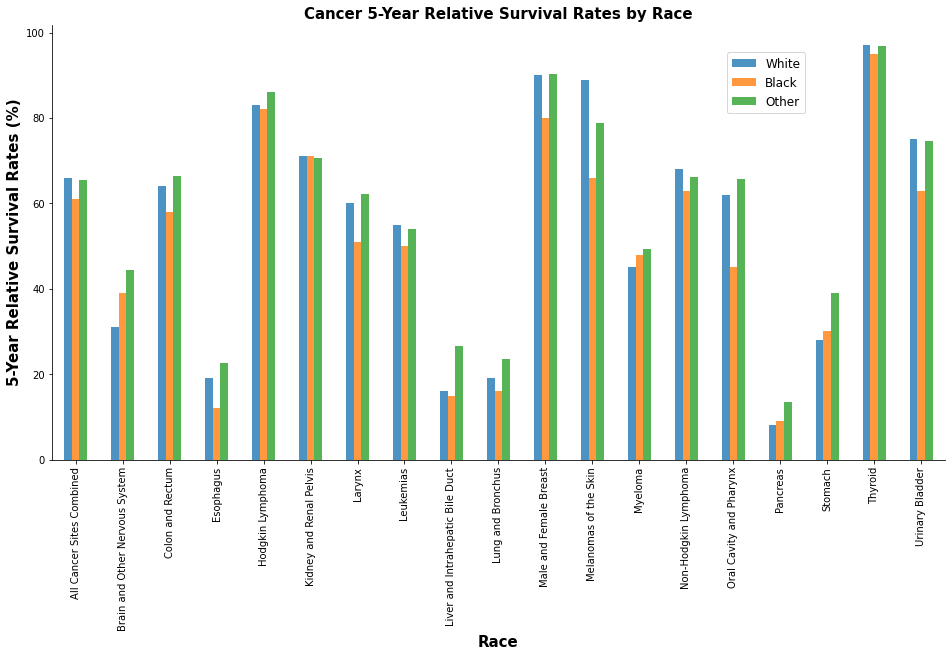

In [21]:
# Create graph of 5 year survival rates by race

fig, ax = plt.subplots(figsize=(16,8))

survival_rates_clean.plot.bar(y=["White 5-year relative survival %", 
                                      "Black 5-year relative survival %",
                                     "Other 5-year relative survival %",
                                     ], ax=ax, alpha=0.8)

ax.set_title("Cancer 5-Year Relative Survival Rates by Race", fontsize=15, fontdict=dict(weight='bold'))
ax.set_ylabel("5-Year Relative Survival Rates (%)", fontsize=15, fontdict=dict(weight='bold'))
ax.set_xlabel("Race", fontsize=15, fontdict=dict(weight='bold'))
ax.legend(bbox_to_anchor=(0.9, 0.95), fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(["White", "Black", "Other"], bbox_to_anchor=(0.85, 0.95), fontsize=12)

fig.savefig("5_year_survival_race.svg", bbox_inches="tight")

plt.show("off")